In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import ast
import base64
import torch
import textstat
import numpy as np
import pandas as pd
from tqdm import tqdm
import datasets as ds
from collections import defaultdict
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    pipeline,
    AutoModelForCausalLM,
    TextGenerationPipeline,
    AutoModelForSequenceClassification,
)
from huggingface_hub import login

HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN", None)
if HUGGINGFACE_TOKEN is not None:
    login(token=HUGGINGFACE_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
torch.manual_seed(42)

#### Loading the test dataset

In [ ]:
dataset = ds.load_from_disk("/scratch1/redditqa/cached_datasets/AskHistorians_test_set_100")

Saving the dataset (1/1 shards): 100%|██████████| 5626/5626 [00:00<00:00, 12062.08 examples/s]


In [ ]:
dfs = {}

for name, qas in model_answers.items():

    rewards = model_rewards[name]

    df = pd.DataFrame.from_records([
        {
            'question': q, f'{name}.answer': a, 
            f'{name}.reward': rewards[q]
        } 
        for q, a in qas.items()
    ])

    dfs[name] = df

first_df_name = list(dfs.keys())[0]
df = dfs[first_df_name]
for name, df_other in dfs.items():
    
    if name == first_df_name:
        continue

    df = df.merge(df_other, on='question')

df

,question,7B_dpo_cp-10000.answer,7B_dpo_cp-10000.reward,7B_dpo_cp-2000.answer,7B_dpo_cp-2000.reward
0,How does new city formation works in US? If me...,Sooner or later they'll notice you. They'll ...,0.757794,"So called ""boom towns"" do indeed spring up ov...",0.953275
1,why aren't CCTV cameras made to produce higher...,CCTV cameras are not made to produce footage ...,0.930458,CCTV footage is not intended for identificati...,0.930458
2,how is Bill Gates still so rich if he is givin...,So go ahead and do it! We're doing it with you.,0.762070,"So far, Bill Gates has given $28 billion to t...",0.957912
3,How did America become so powerful despite bei...,So many other countries were fighting for Ame...,0.812867,So many factors went into America's rise to p...,0.983597
4,How do they make white gold? Can it be melted ...,"So-called ""white gold"" is actually an alloy o...",0.927363,"So-called ""white gold"" is actually an alloy o...",0.941654
...,...,...,...,...,...
195,"In a roll of duct tape, how does the glue stic...",So /'s/ not glue. It's tape. Tape is made o...,0.919643,Soooooooooooooooooooooooooooooooooooooooooooo...,0.623377
196,How do popular social media apps become popula...,Softwaare like facebook weren't popular at st...,0.912436,Softwaare like twitter didn't start with 0 us...,0.894789
197,Are we fishing at too high of a rate? Are we g...,So many bass are being caught each year that ...,0.800692,So many bass are being caught each year that ...,0.791821
198,What is a freemason and why is it such a secre...,So you're telling me you've been to a meeting...,0.841826,So you're telling me you've never heard of th...,0.787931


#### Textstat and toxicity scores

In [ ]:
toxicity_pipe = pipeline("text-classification", model="tomh/toxigen_roberta")


def mean_std(col, precision=2): 
    col_mean = col.mean()
    col_std = col.std()
    return f'{col_mean:.{precision}f} ± {col_std:.{precision}f}'


def run_toxicity_pipe(text):
    try: 
        result = toxicity_pipe(text, top_k=None)
        result = [r for r in result if r['label'] == 'LABEL_1'][0]
    except:
        return 0.5

    return result['score']


metrics_list = []
for col in df.columns:

    if col == 'question':
        continue

    if not col.endswith('.answer'):
        continue

    name = col.replace('.answer', '')

    # Apply textstat functions
    text_standard = df[col].apply(lambda t: textstat.text_standard(t, float_output=True))
    reading_time = df[col].apply(textstat.reading_time)
    df[name + '.text_standard'] = text_standard
    df[name + '.reading_time'] = reading_time

    # Measure toxicity
    toxicity = df[col].apply(run_toxicity_pipe)

    # Save metrics
    metrics_list.append({
        'name': name,
        'text_standard [grade]': mean_std(text_standard),
        'reading_time [s]': mean_std(reading_time),
        'toxicity [0-1]': mean_std(toxicity, precision=3),
    })

    # Print metrics
    print(f'{name}:')
    print('\n'.join([f'  {k}: {v}' for k, v in metrics_list[-1].items()]))

    # Print further info on rewards
    df[name + '.reward'].hist(bins=20, figsize=(4, 2))
    plt.title(name + '.reward')
    plt.show()


In [ ]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index('name').sort_index()
metrics_df.to_markdown('metrics_model_comparison.md')
metrics_df

,text_standard [grade],reading_time [s],toxicity [0-1],reward [0-1]
name,,,,
7B_dpo_cp-10000,8.10 ± 10.33,2.19 ± 1.26,0.020 ± 0.085,0.872 ± 0.084
7B_dpo_cp-2000,7.13 ± 3.42,2.16 ± 1.18,0.042 ± 0.155,0.883 ± 0.071


Review an example row

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(pd.DataFrame(df.iloc[0]))

,0
question,"How does new city formation works in US? If me and my 50 friend purchase land in middle of nowhere, build homes and start living there, will it be designated as city by state government?"
7B_dpo_cp-10000.answer,Sooner or later they'll notice you. They'll come and they'll make you leave.
7B_dpo_cp-10000.reward,0.757794
7B_dpo_cp-2000.answer,"So called ""boom towns"" do indeed spring up overnight, but they're not started by 50 people. They're started by an oil company, a mining company, a logging company, a sawmill, a cattle ranch, or some similar business. The 50 people you're thinking of are called """
7B_dpo_cp-2000.reward,0.953275
7B_dpo_cp-10000.text_standard,5.0
7B_dpo_cp-10000.reading_time,0.94
7B_dpo_cp-2000.text_standard,7.0
7B_dpo_cp-2000.reading_time,3.19


#### Data for Human Annotators 

Generate sheet to compare models for human annotators. We focus on the baseline and the two checkpoints after 2500 and 8500 steps. We compare to the left and make sure that the order is randomized

In [ ]:
def encode_metadata(metadata):
    metadata = repr(metadata)
    metadata = metadata.encode('utf-8')
    metadata = base64.b64encode(metadata)
    return metadata

def decode_metadata(metadata):
    metadata = metadata[2:-1]  # remove b' and '
    metadata = base64.b64decode(metadata)
    metadata = metadata.decode('utf-8')
    metadata = ast.literal_eval(metadata)
    return metadata

In [ ]:
def create_comparison(col1, col2): 

    # Create a new dataframe with the two columns
    comparisons = []

    for i, row in df.iterrows():

        question = row['question']
        answer1 = row[col1]
        answer2 = row[col2]

        do_swap = np.random.choice([True, False])


        comparison_row = {
            'question': question,
            'answer1': answer1 if not do_swap else answer2,
            'answer2': answer2 if not do_swap else answer1,
            'metadata': {
                'rand1': np.random.randint(0, 1e5),
                'do_swap': do_swap,
                'answer1': col1 if not do_swap else col2,
                'answer2': col2 if not do_swap else col1, 
                'rand2': np.random.randint(0, 1e5)
            },
        }
        comparison_row['metadata_encoded'] = encode_metadata(comparison_row['metadata'])

        comparisons.append(comparison_row)

    df_comparisons = pd.DataFrame.from_records(comparisons)
    return df_comparisons

#with pd.option_context('display.max_colwidth', None):
#    display(create_comparison('baseline.answer', 'checkpoint-2500.answer'))

In [ ]:
df.columns

Index(['question', '7B_dpo_cp-10000.answer', '7B_dpo_cp-10000.reward',
       '7B_dpo_cp-2000.answer', '7B_dpo_cp-2000.reward',
       '7B_dpo_cp-10000.text_standard', '7B_dpo_cp-10000.reading_time',
       '7B_dpo_cp-2000.text_standard', '7B_dpo_cp-2000.reading_time'],
      dtype='object')

In [ ]:
create_comparison('3B_baseline.answer', '3B_cp-2500.answer')\
    .head(100)\
    .to_excel('Model Comparison - 3B Baseline vs 3B SFT (n100).xlsx')

create_comparison('7B_baseline.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('Model Comparison - 7B Baseline vs 7B SFT (n100).xlsx')

#### EDA on Data from Human Annotators

First, let's count the votes

In [ ]:
comparison_files = [
    'labelled_data/Model Comparison - Baseline vs Checkpoint-2500 (n200).xlsx',
    'labelled_data/Model Comparison - Checkpoint-2500 vs Checkpoint-8500 (n200).xlsx',
    'labelled_data/Model Comparison - 3B Baseline vs 3B SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B Baseline vs 7B SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B-Chat PPO vs 7B Chat SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B PPO vs 7B SFT (n100).xlsx'
]


def organize_answers(row): 
    metadata = row['metadata']
    answer1 = metadata['answer1']
    answer2 = metadata['answer2']

    return {answer1: row['answer1'], answer2: row['answer2']}


comparisons = []
answers = {}
for comparison_file in comparison_files:

    # Load comparison data
    comparison_df = pd.read_excel(comparison_file)

    # Decode metadata
    comparison_df["metadata"] = comparison_df.metadata_encoded.apply(decode_metadata)
    comparison_df.drop(columns=["metadata_encoded"], inplace=True)
    comparison_df.metadata = comparison_df.metadata.apply(lambda d: {k: v for k, v in d.items() if k not in ['rand1', 'rand2']})

    # Fix column names
    comparison_df.drop(columns=["assignee1"], inplace=True, errors="ignore")
    comparison_df.rename(columns={"label1": "label"}, inplace=True, errors="ignore")

    # Count votes
    counters = defaultdict(int)
    for _, row in comparison_df.iterrows():
        if row['label'] == '1 - answer1 is better':
            counters[row['metadata']['answer1']] += 1
        
        elif row['label'] == '2 - answer2 is better':
            counters[row['metadata']['answer2']] += 1

        elif row['label'] == '3 - both are equal':
            counters['parity'] += 1

    # Organize answers
    answers_pair = comparison_df.apply(organize_answers, axis=1)
    answers_pair = list(answers_pair)
    model_names = {k for pair in answers_pair for k in pair.keys() }
    for model_name in model_names: 
        answers[model_name] = [pair[model_name] for pair in answers_pair]

    #print(answers_pair[:2])

    counters = {name: counters[name] for name in sorted(counters.keys())}
    comparisons.append(counters)


# # Create df with answers
# answers = pd.DataFrame(answers)
# #answers.columns = [c.replace('.answer', '') for c in answers.columns]
# answers.insert(0, "question", comparison_df["question"])
#
#
# # Display
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(answers.head(3))

In [ ]:
comparisons

[{'baseline.answer': 78, 'checkpoint-2500.answer': 40, 'parity': 33},
 {'checkpoint-2500.answer': 68, 'checkpoint-8500.answer': 60, 'parity': 46},
 {'3B_baseline.answer': 16, '3B_cp-2500.answer': 53, 'parity': 31},
 {'7B_baseline.answer': 24, '7B_cp-2000.answer': 60, 'parity': 16},
 {'7B-chat_cp-2500.answer': 18, '7B-chat_ppo.answer': 19, 'parity': 15},
 {'7B_cp-2000.answer': 16, '7B_ppo.answer': 17, 'parity': 19}]

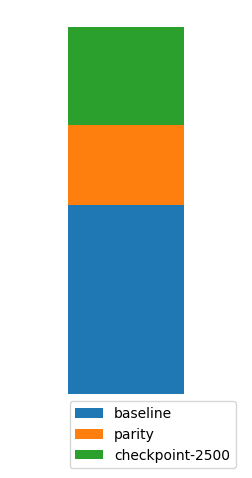

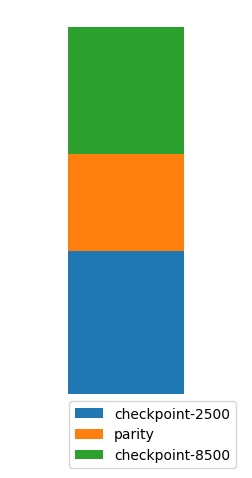

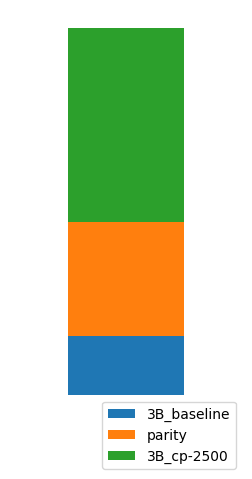

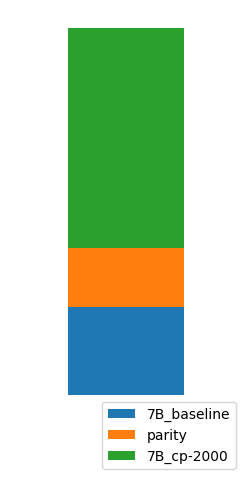

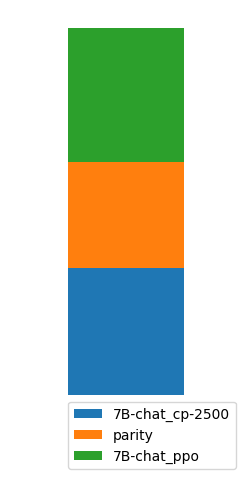

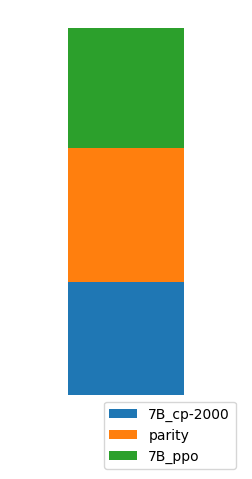

In [ ]:
for comparison in comparisons: 

    keys = list(comparison.keys())
    keys = keys[:1] + ['parity'] + keys[1:2]

    pd.DataFrame([
        {'rating': k.replace('.answer', ''), 'count': comparison[k]} for k in keys
    ]).set_index('rating').T.plot.bar(stacked=True, figsize=(3, 5), legend=False)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1.0, 0.0))
    plt.show()